# Comparison of Mission Arrays with 4.5 m AWAC

In [20]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'

In [14]:
microSWIFT_sig_wave_heights = []
mission_times = []
awac_sig_wave_heights = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)

    microSWIFT_sig_wave_heights.append(mission_tools.compute_sig_wave_height_top_third(wave_heights))

    mission_time = np.median(mission_dataset['time'][:])
    mission_times.append(mission_time)

    awac_sig_wave_heights.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))

/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Compare the Significant Wave Heights between the microSWIFT arrays and the AWAC

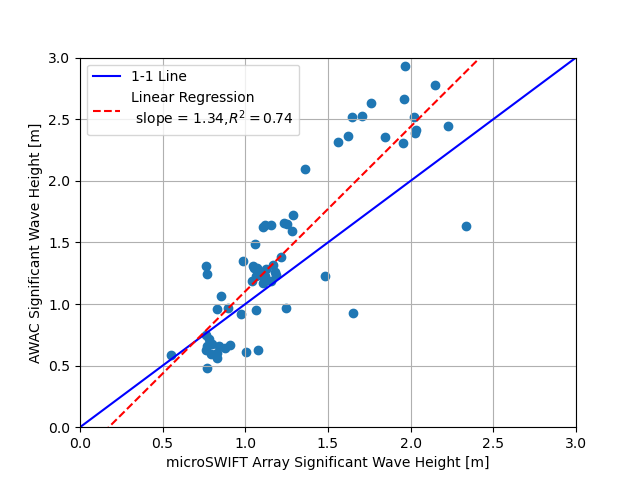

In [16]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope, \
intercept, \
r_value, \
p_value, \
std_err = stats.linregress(microSWIFT_sig_wave_heights,
                          awac_sig_wave_heights)

x = np.linspace(0, 4.5)
y = slope * x + intercept

fig, ax = plt.subplots()
ax.scatter(microSWIFT_sig_wave_heights, awac_sig_wave_heights)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x, y, color='r', linestyle='dashed', 
        label='Linear Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope, r_value**2))
ax.set_xlabel('microSWIFT Array Significant Wave Height [m]')
ax.set_ylabel('AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()

## Compare the Significant Wave Heights as a time series

Text(0, 0.5, 'Significant Wave Height [m]')

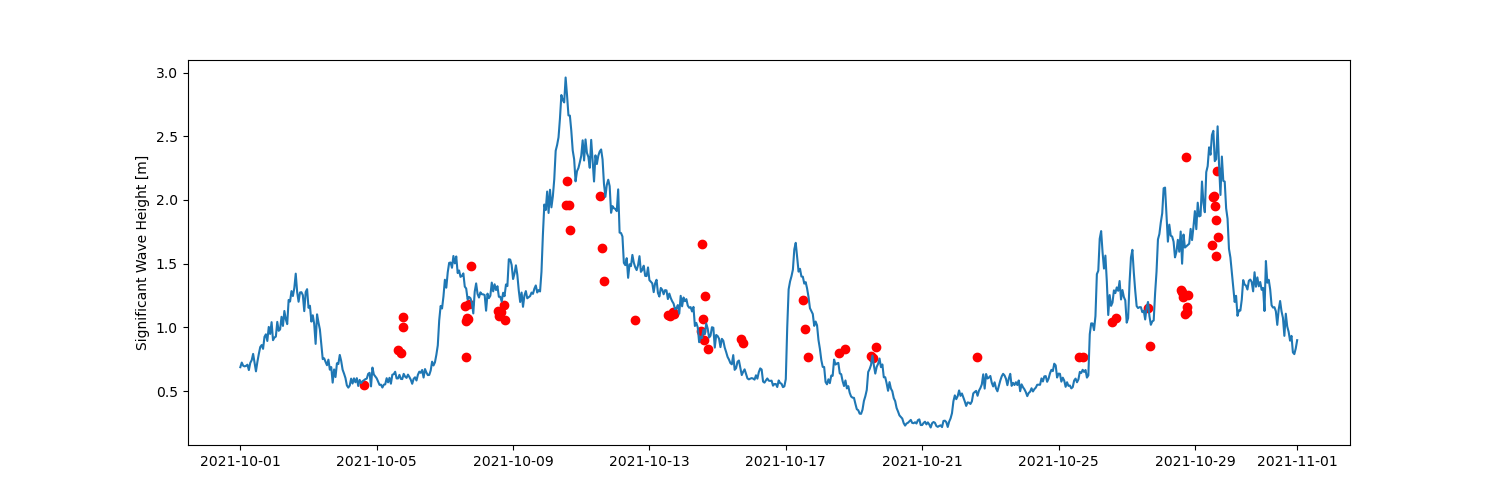

In [30]:
awac_dataset = nc.Dataset(awac_file)
awac_time = cftime.num2pydate(awac_dataset['time'],
                              units=awac_dataset['time'].units,
                              calendar=awac_dataset['time'].calendar)
mission_times_date = cftime.num2pydate(mission_times,
                                       units=mission_dataset['time'].units,
                                       calendar=mission_dataset['time'].calendar)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveHs'][:])
ax.scatter(mission_times_date, microSWIFT_sig_wave_heights, color='r')
ax.set_ylabel('Significant Wave Height [m]')


## Compare only waves between 4-5 meters Bathy to the AWAC

In [39]:
microSWIFT_sig_wave_heights_45 = []
mission_times_45 = []
awac_sig_wave_heights_45 = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)
    
    wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs,
                                                  wave_y_locs,
                                                  bathy_file)
    wave_heights_45 = []
    for n in np.arange(len(wave_bathy)):
        if wave_bathy[n] > -5 and wave_bathy[n] < -4 and ~np.isnan(wave_heights[n]):
            wave_heights_45.append(wave_heights[n])

    if len(wave_heights_45) > 30:
        microSWIFT_sig_wave_heights_45.append(mission_tools.compute_sig_wave_height_top_third(wave_heights_45))

        mission_time = np.median(mission_dataset['time'][:])
        mission_times_45.append(mission_time)

        awac_sig_wave_heights_45.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))
    else:
        continue

/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Compare the significant wave heights between 4-5 meters

In [ ]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_45, \
intercept_45, \
r_value_45, \
p_value_45, \
std_err_45 = stats.linregress(microSWIFT_sig_wave_heights_45,
                              awac_sig_wave_heights_45)

x_45 = np.linspace(0, 4.5)
y_45 = slope_45 * x + intercept_45

fig, ax = plt.subplots()
ax.scatter(microSWIFT_sig_wave_heights_45, awac_sig_wave_heights_45)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_45, y_45, color='r', linestyle='dashed', 
        label='Linear Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope, r_value**2))
ax.set_xlabel('microSWIFT Array Significant Wave Height [m]')
ax.set_ylabel('AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()

In [ ]:
mission_times_date_45 = cftime.num2pydate(mission_times_45,
                                          units=mission_dataset['time'].units,
                                          calendar=mission_dataset['time'].calendar)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveHs'][:])
ax.scatter(mission_times_date_45, microSWIFT_sig_wave_heights_45, color='r')
ax.set_ylabel('Significant Wave Height [m]')